In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import argparse
from baselines.common.running_mean_std import RunningMeanStd
from envs import *
import numpy as np
from utils import *
from skimage.io import imsave
from parser import *
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Storage:
    def __init__(self, size, keys=None):
        if keys is None:
            keys = []
        keys = keys + ['s', 'a', 'r', 'm',
                       'v', 'q', 'pi', 'log_pi', 'ent',
                       'adv', 'ret', 'q_a', 'log_pi_a',
                       'mean']
        self.keys = keys
        self.size = size
        self.reset()

    def add(self, data):
        for k, v in data.items():
            if k not in self.keys:
                self.keys.append(k)
                setattr(self, k, [])
            getattr(self, k).append(v)

    def placeholder(self):
        for k in self.keys:
            v = getattr(self, k)
            if len(v) == 0:
                setattr(self, k, [None] * self.size)

    def reset(self):
        for key in self.keys:
            setattr(self, key, [])

    def cat(self, keys):
        data = [getattr(self, k)[:self.size] for k in keys]
        #dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
        #data = data.type(dtype)
        return map(lambda x: torch.cat(x, dim=0), data)

class DummyBody(nn.Module):
    def __init__(self, state_dim):
        super(DummyBody, self).__init__()
        self.feature_dim = state_dim

    def forward(self, x):
        return x

class BaseNet:
    def __init__(self):
        pass

# TODO: look into nn.init.orthogonal_
def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class CategoricalActorCriticNet(nn.Module, BaseNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 phi_body=None,
                 actor_body=None,
                 critic_body=None,
                 ordinal_distribution=False):
        super(CategoricalActorCriticNet, self).__init__()
        if phi_body is None: phi_body = DummyBody(state_dim)
        if actor_body is None: actor_body = DummyBody(phi_body.feature_dim)
        if critic_body is None: critic_body = DummyBody(phi_body.feature_dim)
        self.phi_body = phi_body
        self.actor_body = actor_body
        self.critic_body = critic_body
        self.fc_action = layer_init(nn.Linear(actor_body.feature_dim, action_dim), 1e-3)
        self.fc_critic = layer_init(nn.Linear(critic_body.feature_dim, 1), 1e-3)
        self.ordinal_distribution = ordinal_distribution

        """ the parameters for the actor and the crititic """
        self.actor_params = list(self.actor_body.parameters()) + list(self.fc_action.parameters())
        self.critic_params = list(self.critic_body.parameters()) + list(self.fc_critic.parameters())
        self.phi_params = list(self.phi_body.parameters())
        self.to(Config.DEVICE)

    def forward(self, obs, action=None):
        # change the dimension order numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
        obs = tensor(obs)
        if args.observation == 'pixel':
            obs = obs.permute(0, 3, 1, 2)
        #image_transform = transforms.Compose([
        #transforms.ToTensor(),
        #])
        #obs = image_transform(obs)

        phi = self.phi_body(obs)
        phi_a = self.actor_body(phi)
        phi_v = self.critic_body(phi)
        logits = self.fc_action(phi_a)
        v = self.fc_critic(phi_v)

        if self.ordinal_distribution:
            """ Ordinal Distribution Network """
            sigmoid = torch.nn.Sigmoid()
            logits =  torch.squeeze(logits, 0)
            s_i = sigmoid(logits)
            one_minus_s = tensor(1) - s_i
            _part_1 = torch.log_(s_i)
            _part_2 = torch.log_(one_minus_s)
            ordinal_logits = [torch.sum(_part_1[:i + 1]).item() + torch.sum(_part_2[i+1:]).item() for i in range(len(s_i))]
            # ordinal_logits = [torch.sum(torch.log_(s_i[:i+1])).item() + torch.sum(torch.log_(one_minus_s[i+1:])).item() for i in range(len(s_i))]

            ordinal_logits = tensor(ordinal_logits)
            ordinal_logits = torch.unsqueeze(ordinal_logits, dim=0)

            dist = torch.distributions.Categorical(logits=ordinal_logits)
        else:
            dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        return {'a': action,
                'log_pi_a': log_prob,
                'ent': entropy,
                'v': v}




class NatureConvBody(nn.Module):
    def __init__(self, in_channels=4):
        super(NatureConvBody, self).__init__()
        self.feature_dim = 512
        self.conv1 = layer_init(nn.Conv2d(in_channels, 32, kernel_size=8, stride=4))
        self.conv2 = layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2))
        self.conv3 = layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1))
        self.fc4 = layer_init(nn.Linear(28 * 28 * 64, self.feature_dim))

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        y = y.view(y.size(0), -1)
        y = F.relu(self.fc4(y))
        return y


class FCBody(nn.Module):
    def __init__(self, state_dim, hidden_units=(64, 64), gate=F.relu):
        super(FCBody, self).__init__()
        dims = (state_dim,) + hidden_units
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.gate = gate
        self.feature_dim = dims[-1]

    def forward(self, x):
        for layer in self.layers:
            x = self.gate(layer(x))
        return x

class BaseAgent:
    def __init__(self, config):
        self.config = config
        self.logger = get_logger(tag=config.tag, log_level=config.log_level)
        self.task_ind = 0

    def close(self):
        close_obj(self.task)

    def save(self, filename):
        torch.save(self.network.state_dict(), '%s.model' % (filename))
        with open('%s.stats' % (filename), 'wb') as f:
            pickle.dump(self.config.state_normalizer.state_dict(), f)

    def load(self, filename):
        state_dict = torch.load('%s.model' % filename, map_location=lambda storage, loc: storage)
        self.network.load_state_dict(state_dict)
        with open('%s.stats' % (filename), 'rb') as f:
            self.config.state_normalizer.load_state_dict(pickle.load(f))

    def eval_step(self, state):
        raise NotImplementedError

    def eval_episode(self):
        env = self.config.eval_env
        state = env.reset()
        while True:
            action = self.eval_step(state)
            state, reward, done, info = env.step(action)
            ret = info[0]['episodic_return']
            if ret is not None:
                break
        return ret

    def eval_episodes(self):
        episodic_returns = []
        for ep in range(self.config.eval_episodes):
            total_rewards = self.eval_episode()
            episodic_returns.append(np.sum(total_rewards))
        self.logger.info('steps %d, episodic_return_test %.2f(%.2f)' % (
            self.total_steps, np.mean(episodic_returns), np.std(episodic_returns) / np.sqrt(len(episodic_returns))
        ))
        self.logger.add_scalar('episodic_return_test', np.mean(episodic_returns), self.total_steps)
        return {
            'episodic_return_test': np.mean(episodic_returns),
        }

    def record_online_return(self, info, offset=0):
        if isinstance(info, dict):
            ret = info['episodic_return']
            if ret is not None:
                self.logger.add_scalar('episodic_return_train', ret, self.total_steps + offset)
                self.logger.info('steps %d, episodic_return_train %s' % (self.total_steps + offset, ret))
        elif isinstance(info, tuple):
            for i, info_ in enumerate(info):
                self.record_online_return(info_, i)
        else:
            raise NotImplementedError

    def switch_task(self):
        config = self.config
        if not config.tasks:
            return
        segs = np.linspace(0, config.max_steps, len(config.tasks) + 1)
        if self.total_steps > segs[self.task_ind + 1]:
            self.task_ind += 1
            self.task = config.tasks[self.task_ind]
            self.states = self.task.reset()
            self.states = config.state_normalizer(self.states)

    def record_episode(self, dir, env):
        mkdir(dir)
        steps = 0
        state = env.reset()
        while True:
            self.record_obs(env, dir, steps)
            action = self.record_step(state)
            state, reward, done, info = env.step(action)
            ret = info[0]['episodic_return']
            steps += 1
            if ret is not None:
                break

    def record_step(self, state):
        raise NotImplementedError

    # For DMControl
    def record_obs(self, env, dir, steps):
        env = env.env.envs[0]
        obs = env.render(mode='rgb_array')
        imsave('%s/%04d.png' % (dir, steps), obs)


class PPOAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        self.task = config.task_fn()
        self.network = config.network_fn()  # don't put .to(device) here
        self.opt = config.optimizer_fn(self.network.parameters())
        self.total_steps = 0
        self.states = self.task.reset()
        self.states = config.state_normalizer(self.states)
        self.episodic_returns = []
    def step(self):
        config = self.config
        storage = Storage(config.rollout_length) # initialize the storage
        states = self.states # the starting state

        """ Collect a trajectory """
        for _ in range(config.rollout_length):
            prediction = self.network(states)  # a: action, log_pi_a: log_prob, ent: entropy, v: value
            next_states, rewards, terminals, info = self.task.step(to_np(prediction['a']))
            if info[0]['episodic_return'] is not None:
                self.episodic_returns.append(info[0]['episodic_return'])
            self.record_online_return(info)
            #TODO: check out these normalizers
            rewards = config.reward_normalizer(rewards)
            next_states = config.state_normalizer(next_states)
            storage.add(prediction)
            storage.add({'r': tensor(rewards).unsqueeze(-1),
                         'm': tensor(1 - terminals).unsqueeze(-1), # to decide where the state is a terminal state
                         's': tensor(states)})
            states = next_states
            self.total_steps += config.num_workers

        self.states = states
        prediction = self.network(states)
        storage.add(prediction)
        storage.placeholder()

        """ Calculate the advantage function for each state """
        advantages = tensor(np.zeros((config.num_workers, 1)))
        returns = prediction['v'].detach()
        for i in reversed(range(config.rollout_length)):
            returns = storage.r[i] + config.discount * storage.m[i] * returns
            if not config.use_gae:  # TODO: check out general advantage estimate
                advantages = returns - storage.v[i].detach()
            else:
                td_error = storage.r[i] + config.discount * storage.m[i] * storage.v[i + 1] - storage.v[i]
                advantages = advantages * config.gae_tau * config.discount * storage.m[i]+ td_error
            storage.adv[i] = advantages.detach() # store the advantage of each state in one rollout
            storage.ret[i] = returns.detach() # store the discounted sum of rewards

        states, actions, log_probs_old, returns, advantages = storage.cat(['s', 'a', 'log_pi_a', 'ret', 'adv'])
        actions = actions.detach()
        log_probs_old = log_probs_old.detach()
        # advantages = (advantages - advantages.mean()) / advantages.std()  # normalize the advantages => do we really need this? seems like it doesn't help a lot

        """ Update the policy by maximizing the PPO-Clip objective
            by config.optimization_epochs epochs
        """
        for _ in range(config.optimization_epochs):

            sampler = random_sample(np.arange(states.size(0)), config.mini_batch_size) # create a generator of random indices in batches, states.size: 2048, mini_batch_size: 64
            for batch_indices in sampler:
                batch_indices = tensor(batch_indices).long()
                sampled_states = states[batch_indices]   # this method of slicing only works in pytorch tensors
                sampled_actions = actions[batch_indices]
                sampled_log_probs_old = log_probs_old[batch_indices]
                sampled_returns = returns[batch_indices]
                sampled_advantages = advantages[batch_indices]

                prediction = self.network(sampled_states, sampled_actions)  # GaussianActorCriticNet
                ratio = (prediction['log_pi_a'] - sampled_log_probs_old).exp()
                obj = ratio * sampled_advantages
                obj_clipped = ratio.clamp(1.0 - self.config.ppo_ratio_clip,
                                          1.0 + self.config.ppo_ratio_clip) * sampled_advantages # .clamp() is also a special function in pytorch
                policy_loss = -torch.min(obj, obj_clipped).mean() - config.entropy_weight * prediction['ent'].mean()
                value_loss = 0.5 * (sampled_returns- prediction['v']).pow(2).mean()

                self.opt.zero_grad()
                (policy_loss + value_loss).backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), config.gradient_clip) # do gradient clipping in-place
                self.opt.step()

def ppo_pixel(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)
    config.video_rendering = True
    config.task_fn = lambda: Task(config.game, config.video_rendering, num_envs=config.num_workers)
    config.eval_env = config.task_fn()
    config.num_workers = 1
    config.optimizer_fn = lambda params: torch.optim.Adam(params, lr=3e-4, eps=1e-5)
    #config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=0.00025, alpha=0.99, eps=1e-5)
    config.network_fn = lambda: CategoricalActorCriticNet(config.state_dim, config.action_dim, NatureConvBody(in_channels=3))
    config.state_normalizer = ImageNormalizer()
    config.reward_normalizer = SignNormalizer()
    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 0.95
    config.entropy_weight = 0.01
    config.gradient_clip = 0.5
    config.rollout_length = 128
    config.optimization_epochs = 10
    config.mini_batch_size = 64
    config.ppo_ratio_clip = 0.2
    config.log_interval = 2048
    config.max_steps = 1e5
    config.save_interval = 10000




    agent = PPOAgent(config)
    run_steps(agent)
    # plot the episodic returns
    import pylab
    pylab.figure(0)
    pylab.plot(agent.episodic_returns, 'b')
    pylab.xlabel("Episodes")
    pylab.ylabel("Episodic return")
    pylab.savefig("pic/ppo_discrete/pixel.png")
    # run_steps(PPOAgent(config))

def ppo_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.num_workers = 1 #  originally = 5
    config.video_rendering = True
    config.task_fn = lambda: Task(config.game, config.video_rendering,num_envs=config.num_workers)
    config.eval_env = config.task_fn()
    # config.eval_env = Task(config.game)
    config.optimizer_fn = lambda params: torch.optim.Adam(params, lr=3e-4, eps=1e-5)
    config.network_fn = lambda: CategoricalActorCriticNet(config.state_dim, config.action_dim, FCBody(config.state_dim), ordinal_distribution=False)
    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 0.95
    config.entropy_weight = 0.01
    config.gradient_clip = 5
    config.rollout_length = 128
    config.optimization_epochs = 10
    config.mini_batch_size = 32 * 5
    config.ppo_ratio_clip = 0.2
    config.log_interval = 128 * 5 * 10
    # added by chingandy
    config.state_normalizer = MeanStdNormalizer()
    config.max_steps = 1e5

    agent = PPOAgent(config)
    run_steps(agent)


    # plot the episodic returns
    import pylab
    pylab.figure(0)
    pylab.plot(agent.episodic_returns, 'b')
    pylab.xlabel("Episodes")
    pylab.ylabel("Episodic return")
    pylab.savefig("pic/ppo_discrete/cartpole.png")
   
if __name__ == '__main__':
    mkdir('log')
    mkdir('tf_log')
    set_one_thread()
    random_seed()
    select_device(0) # select_device(gpu_id)

    env = "MountainCar-v0"
    ppo_feature(game=env)
    
#     if args.observation == 'pixel':
#         env = "Reacher-v101"
#         ppo_pixel(game=env)
#     elif args.observation == 'feature_n_detector':
#         # print("argument parser works")
#         env = 'Reacher-v102'
#         ppo_feature(game=env)
#     elif args.observation == "cart":
#         env = "CartPole-v0"
#         ppo_feature(game=env)
#     elif args.observation == "mountain-car":
#         env = "MountainCar-v0"
#         ppo_feature(game=env)
#     else:
#         print("Observation space isn't specified.")




In [8]:
import gym
env = gym.make("Reacher-v2")

In [10]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [13]:
frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = env.action_space.sample()
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
#     agent.stop_episode()
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

test episode: 0 R: -41.87823114984594
test episode: 1 R: -47.120810941919544
test episode: 2 R: -46.45005692415613
GLFW error (code %d): %s 65544 b'X11: RandR gamma ramp support seems broken'
GLFW error (code %d): %s 65542 b'EGL: Failed to get EGL display: Success'
Creating window glfw
GLFW error (code %d): %s 65543 b'Requested client API version 1.0, got version 0.0'


GlfwError: Failed to create GLFW window

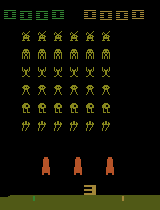

In [18]:
import gym, PIL
env = gym.make('SpaceInvaders-v0')
array = env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))